# Principal Component Analysis

Principal Component Analysis (or PCA) is widely used for dimension reduction and classification. Treating rows as observations and columns as variables we will form a covariance matrix (real-symmetric, why?) of the variables and diagonalize. The diagonalization is guaranteed since covariance matrices are square, real, and symmetric. Further, by the Spectral Theorem we are also guaranteed positive distinct eigenvalues with associated orthonormal eigenvectors. It is these associated eigenvectors that will serve as "principal" components (basis) for what is effectively a change of basis.

Even better yet, the eigenvalues represent the "energy" contribution of each component to the system. Since the eigenvalues are distinct and positive, the sum of the $\lambda_i$'s (or trace of the covariance matrix) represent the total energy, and we can rank the eigenvalues from largest to smallest, 

$$ \lambda_1 \; > \; \lambda_2 \; > \; \lambda_3 \; > \; \ldots \; > \; \lambda_n \; > \; 0.$$

Choosing the first two or three principal components we can graph the data points on new axes given by these principal components (PC1, PC2, etc.) Note that the principal components themselves are each a linear combination of the orginal variables (which should be thought of as an original standard basis of the system with each variable having its own "axis" in $\mathbb{R}^n$.)


Let's dive into an example using the Palmer Penguins data set created and made available by [Alison Horst](https://allisonhorst.github.io/palmerpenguins/articles/pca.html).

We will need the `penguins.csv` file in our workspace or filepath.

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from IPython.display import HTML
from matplotlib import animation

In [3]:
np.set_printoptions(linewidth = 200)

## Load data

Make sure that you have `penguins.csv` accessible to your workspace.

1. First we bring in the data set as a data frame using the `pandas` `read_csv()` command.
2. Next we copy the variables of interest into a numpy array so we can use numpy and linear algebra!


In [7]:
# Load data frame
penguins = pd.read_csv("penguins.csv")
penguins = penguins.dropna(axis = 0)
penguins

,rowid,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,1,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,2,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,3,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,5,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,6,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007
...,...,...,...,...,...,...,...,...,...
339,340,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,341,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,342,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,343,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


In [8]:
penguins_np = penguins.iloc[:, 3:7]
X = penguins_np.to_numpy(copy = True)

X

array([[  39.1,   18.7,  181. , 3750. ],
       [  39.5,   17.4,  186. , 3800. ],
       [  40.3,   18. ,  195. , 3250. ],
       ...,
       [  49.6,   18.2,  193. , 3775. ],
       [  50.8,   19. ,  210. , 4100. ],
       [  50.2,   18.7,  198. , 3775. ]])

## Look at your data

Looking briefly at the pandas dataframe `penguins` that we loaded can give us some quick information on the variables we have access to.

The matrix $X$ we have loaded as a numpy array in the code cell above contains what information?

### Question 1

> 1a. What do the rows and columns of X represent?

> For every rows there are 4 columns being imported filtering everything else in the data
> 
> 1b. How many and which numerical variables are we considering? Name them.

> bill_length_mm, bill_depth_mm, flipper_length_mm, body_mass_g
> 
> 1c How many rows are in the original imported penguins.csv?

> 339
>
> 1d. How many rows are in X? Why the difference?

> 333 rows. We dropped NA rows
> 

In [12]:
# Check out the shape of X to answer the previous row and col questions. 
X, type(X), X.shape

(array([[  39.1,   18.7,  181. , 3750. ],
        [  39.5,   17.4,  186. , 3800. ],
        [  40.3,   18. ,  195. , 3250. ],
        ...,
        [  49.6,   18.2,  193. , 3775. ],
        [  50.8,   19. ,  210. , 4100. ],
        [  50.2,   18.7,  198. , 3775. ]]),
 numpy.ndarray,
 (333, 4))

## Categorical variables

While we can only do linear algebra on numerical data (vectors and matrices as numpy arrays) we can use the categorical variables given (`species` and `island`) to classify or categorize using PCA. Take a quick look in the data frame output above and the code below.

In [15]:
# We can also access categorical variables from the data frame
species, island = penguins.iloc[:,1], penguins.iloc[:, 2]
species, island

(0         Adelie
 1         Adelie
 2         Adelie
 4         Adelie
 5         Adelie
          ...    
 339    Chinstrap
 340    Chinstrap
 341    Chinstrap
 342    Chinstrap
 343    Chinstrap
 Name: species, Length: 333, dtype: object,
 0      Torgersen
 1      Torgersen
 2      Torgersen
 4      Torgersen
 5      Torgersen
          ...    
 339        Dream
 340        Dream
 341        Dream
 342        Dream
 343        Dream
 Name: island, Length: 333, dtype: object)

In [17]:
NROW = X.shape[0]
NROW

333

In [19]:
# The eigenvalues given in d give the energy distribution across components.
# unscaled, raw data covariance matrix
cov_x = np.cov(X.T)
d_x, V_x = np.linalg.eig(cov_x)
d_x, V_x

(array([6.48533462e+05, 5.07358125e+01, 1.61549819e+01, 2.36086761e+00]),
 array([[-4.00316167e-03, -3.19277728e-01, -9.41264749e-01, -1.09847074e-01],
        [ 1.15432728e-03,  8.68475312e-02, -1.44494794e-01,  9.85686273e-01],
        [-1.51945474e-02, -9.43542375e-01,  3.05189864e-01,  1.27890806e-01],
        [-9.99875876e-01,  1.57170210e-02, -1.03610977e-03, -3.65748162e-04]]))

In [21]:
# Should be a 4 x 4 identity matrix.
V_x.T@V_x

array([[ 1.00000000e+00,  7.15683270e-17,  1.69465631e-16,  1.91651205e-16],
       [ 7.15683270e-17,  1.00000000e+00, -1.44626668e-15,  5.16846300e-15],
       [ 1.69465631e-16, -1.44626668e-15,  1.00000000e+00, -1.67629509e-14],
       [ 1.91651205e-16,  5.16846300e-15, -1.67629509e-14,  1.00000000e+00]])

In [23]:

PC1, PC2, PC3 = X@V_x[:, 0], X@V_x[:, 1], X@V_x[:,2]

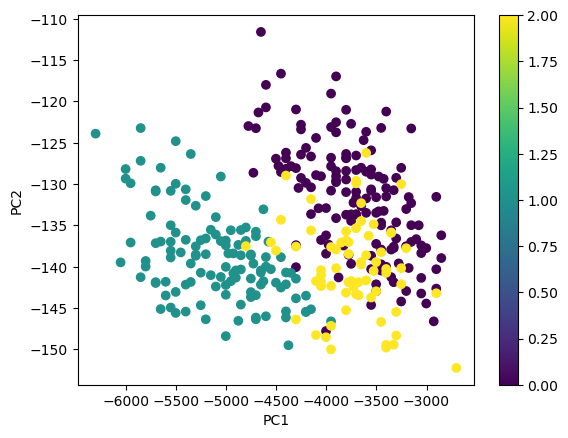

In [25]:
plt.scatter( PC1, PC2, c = pd.factorize(penguins['species'])[0] )
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.show()

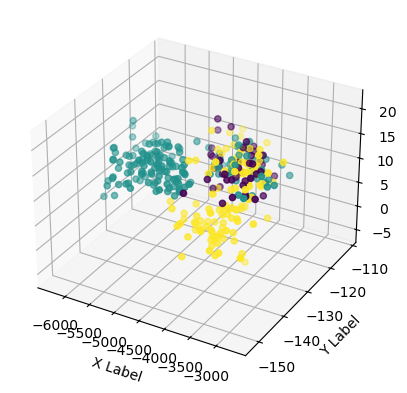

In [27]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(PC1, PC2, PC3, c = pd.factorize( penguins['island'])[0] )
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

In [ ]:
# fig = plt.figure()
# ax = fig.add_subplot( projection='3d' )
# ax.scatter( PC1, PC2, PC3, c = pd.factorize(penguins['island'])[0] )
# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')
# plt.show()

# def animate(frame):
#   ax.view_init(30, frame/4)
#   plt.pause(.001)
#   return fig

# anim = animation.FuncAnimation(fig, animate, frames=400, interval=50)
# HTML(anim.to_html5_video())

In [29]:
z_scores = stats.zscore(X)
cov_z = np.cov(z_scores.T)
cov_z, cov_z.shape

(array([[ 1.00301205, -0.22931427,  0.65506279,  0.59122657],
        [-0.22931427,  1.00301205, -0.57953203, -0.47343739],
        [ 0.65506279, -0.57953203,  1.00301205,  0.87560835],
        [ 0.59122657, -0.47343739,  0.87560835,  1.00301205]]),
 (4, 4))

In [31]:
d, V = np.linalg.eig(cov_z)
d, V

(array([2.75362487, 0.7804609 , 0.36975289, 0.10820954]),
 array([[-0.45375317,  0.6001949 ,  0.64249509,  0.14516955],
        [ 0.39904723,  0.79616951, -0.42580043, -0.1599044 ],
        [-0.576825  ,  0.00578817, -0.23609516, -0.78198369],
        [-0.54967471,  0.07646366, -0.59173738,  0.58468615]]))

In [33]:
sum(d)

4.0120481927710845

In [49]:
PC1z, PC2z, PC3z = z_scores@V[:, 0], z_scores@V[:, 1], z_scores@V[:,2]

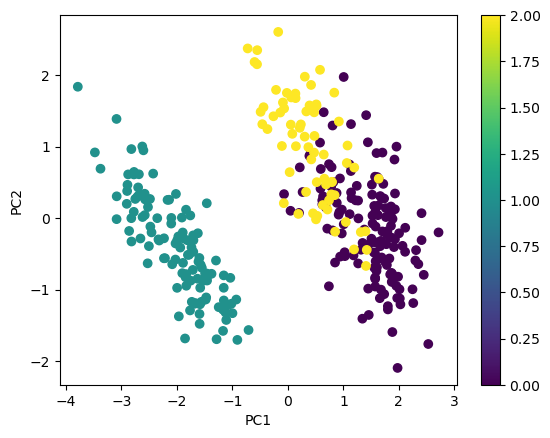

In [51]:
plt.scatter( PC1z, PC2z, c = pd.factorize(penguins['species'])[0] )
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.show()

In [59]:
U, S, VH = np.linalg.svd(z_scores, full_matrices = False)
print(U.shape, S.shape, VH.shape)

(333, 4) (4,) (4, 4)


In [61]:
r2 = U[:, :2] @ np.diag(S[:2]) @ VH[:2, :]
r2.shape

(333, 4)

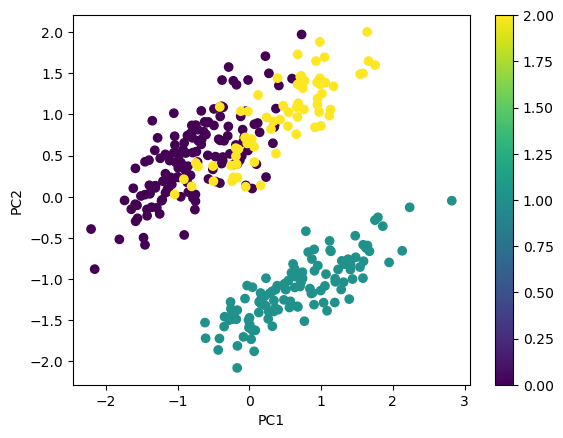

In [63]:
plt.scatter( r2[:, 0], r2[:, 1], c = pd.factorize(penguins['species'])[0] )
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.show()